In [119]:
import torch
from torch import nn
from torchvision import datasets, transforms

from matplotlib import pyplot as plt

import backpack
import copy

from torch_kfac import KFAC

In [132]:
### simple cnn for mnist:

def get_model():

    first_layer = nn.Conv2d(1, 32, 3)

    net = nn.Sequential(
        first_layer,
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32, 64, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64, 128, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(128, 256, 3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, 3, padding=1),
        nn.Flatten(),
        nn.Linear(2304, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    return net

loss_fn = nn.CrossEntropyLoss()

# backpack.extend(net)
# backpack.extend(loss_fn)

In [129]:
## load mnist data:

data = datasets.MNIST('~/mldata', train=True, download=False, transform=transforms.ToTensor())

dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

In [ ]:
losses = []
alpha = 1e-1
net = get_model()

for x,y in dataloader:
    y_pred = net(x)
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())
    
    loss.backward()
    
    with torch.no_grad():
        for p in net.parameters():
            p -= alpha * p.grad
    net.zero_grad()


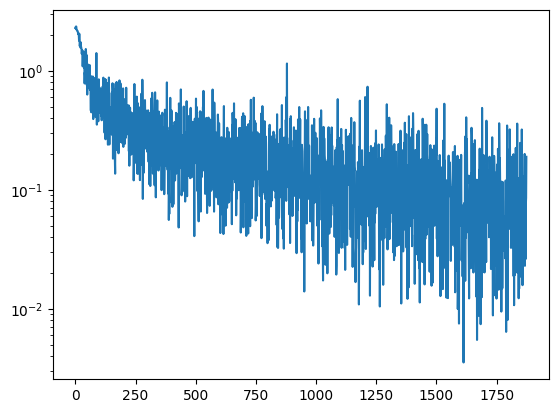

In [5]:
plt.plot(losses)
plt.yscale('log')

In [6]:
for x,y in dataloader:
    y_pred = net(x)
    loss = loss_fn(y_pred, y)
    with backpack.backpack(backpack.extensions.KFAC()):
        loss.backward()
    break



In [7]:
kfacs = []
for p in net.parameters():
    print([kfac.shape for kfac in p.kfac])
    kfacs.append(copy.deepcopy(p.kfac))

[torch.Size([32, 32]), torch.Size([9, 9])]
[torch.Size([32, 32])]
[torch.Size([128, 128]), torch.Size([5408, 5408])]
[torch.Size([128, 128])]
[torch.Size([10, 10]), torch.Size([128, 128])]
[torch.Size([10, 10])]


In [8]:
inv_kfacs = []
for kfac in kfacs:
    if len(kfac) == 1:
        inv_kfacs.append(
            torch.linalg.inv(kfac[0] + 1e-3 * torch.eye(kfac[0].shape[0]))
        )
    elif len(kfac) == 2:
        inv_kfacs.append(
            torch.kron(
                torch.linalg.inv(kfac[0] + 1e-3 * torch.eye(kfac[0].shape[0])),
                torch.linalg.inv(kfac[1] + 1e-3 * torch.eye(kfac[1].shape[0]))
            )
        )
    else:
        raise ValueError('kfac has too many dimensions')
    break

In [10]:
inv_kfacs[0].shape

torch.Size([288, 288])

In [12]:
for p in net.parameters():
    grad = torch.matmul(inv_kfacs[0], p.grad.flatten()).reshape(p.grad.shape)
    break

torch.Size([32, 1, 3, 3])

In [152]:
net = get_model()
kfac = KFAC(net, learning_rate=2e-3, damping=1e-2)

In [153]:
losses = []

for x,y in dataloader:
    net.zero_grad()
    with kfac.track_forward():
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
    
    with kfac.track_backward():
        loss.backward()

    kfac.step(loss = loss)
    losses.append(float(loss))
    print(loss)

/Users/bt307730/.venvs/torch/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


tensor(2.3028, grad_fn=<NllLossBackward0>)
tensor(2.3015, grad_fn=<NllLossBackward0>)
tensor(2.3029, grad_fn=<NllLossBackward0>)
tensor(2.3037, grad_fn=<NllLossBackward0>)
tensor(2.3007, grad_fn=<NllLossBackward0>)
tensor(2.2971, grad_fn=<NllLossBackward0>)
tensor(2.2920, grad_fn=<NllLossBackward0>)
tensor(2.2992, grad_fn=<NllLossBackward0>)
tensor(2.2986, grad_fn=<NllLossBackward0>)
tensor(2.2996, grad_fn=<NllLossBackward0>)
tensor(2.3089, grad_fn=<NllLossBackward0>)
tensor(2.3028, grad_fn=<NllLossBackward0>)
tensor(2.3009, grad_fn=<NllLossBackward0>)
tensor(2.3000, grad_fn=<NllLossBackward0>)
tensor(2.3002, grad_fn=<NllLossBackward0>)
tensor(2.2899, grad_fn=<NllLossBackward0>)
tensor(2.2865, grad_fn=<NllLossBackward0>)
tensor(2.2959, grad_fn=<NllLossBackward0>)
tensor(2.2811, grad_fn=<NllLossBackward0>)
tensor(2.2887, grad_fn=<NllLossBackward0>)
tensor(2.2818, grad_fn=<NllLossBackward0>)
tensor(2.2762, grad_fn=<NllLossBackward0>)
tensor(2.2713, grad_fn=<NllLossBackward0>)
tensor(2.27

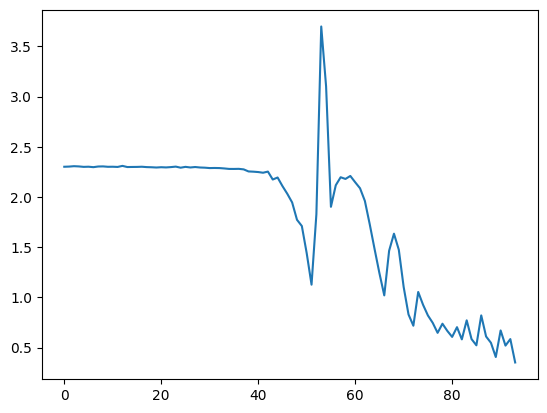

In [141]:
plt.plot(losses)

In [85]:
kfac.update_cov()
nat_grads = kfac._get_raw_updates()

In [86]:
nat_grads[0][0][0]

tensor([[[[ 5.6298e+04,  4.0685e+04,  1.8748e+04],
          [ 7.9311e+04,  9.0063e+04,  3.6633e+04],
          [ 8.9627e+04,  1.1282e+05,  9.3271e+04]],

         [[ 3.6133e+04,  1.1858e+04, -2.6482e+04],
          [ 4.7675e+04,  4.9986e+04, -1.1821e+04],
          [ 5.4031e+04,  6.8562e+04,  4.2306e+04]],

         [[ 4.4872e+04,  2.6170e+04,  7.4259e+03],
          [ 5.7294e+04,  7.0024e+04,  2.4241e+04],
          [ 6.8965e+04,  9.5430e+04,  7.4031e+04]]],


        [[[-1.3573e+05, -1.1801e+05, -1.2690e+05],
          [-1.5124e+05, -1.5127e+05, -1.5237e+05],
          [-1.3401e+05, -1.4628e+05, -1.4602e+05]],

         [[-1.3729e+05, -1.1557e+05, -1.3689e+05],
          [-1.5308e+05, -1.5208e+05, -1.5706e+05],
          [-1.3495e+05, -1.5469e+05, -1.5467e+05]],

         [[-1.0436e+05, -7.6594e+04, -9.0621e+04],
          [-1.2050e+05, -1.1980e+05, -1.1673e+05],
          [-1.1300e+05, -1.2813e+05, -1.2252e+05]]],


        [[[-8.8938e+03,  1.9425e+03,  3.0215e+04],
          [-4.4